In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import MARBLE
from MARBLE import geometry, plotting

from RNN_scripts import dms, helpers

In [2]:
# download datasets
!mkdir data
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963161 -O data/dms_rank2_500.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963162 -O data/dms_rank2_500_2.pt
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963166 -O data/dms_rank2_500_sampled_1.pt 
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963165 -O data/dms_rank2_500_sampled_2.pt 
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963163 -O data/RNN_trajectories11.pkl 
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963164 -O data/RNN_trajectories12.pkl 
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963158 -O data/RNN_trajectories2.pkl 

mkdir: data: File exists
File ‘data/dms_rank2_500.pt’ already there; not retrieving.
File ‘data/dms_rank2_500_2.pt’ already there; not retrieving.
File ‘data/dms_rank2_500_sampled_1.pt’ already there; not retrieving.
File ‘data/dms_rank2_500_sampled_2.pt’ already there; not retrieving.
File ‘data/RNN_trajectories11.pkl’ already there; not retrieving.
File ‘data/RNN_trajectories12.pkl’ already there; not retrieving.
File ‘data/RNN_trajectories2.pkl’ already there; not retrieving.


# Load trained model

In [3]:
_, net1 = helpers.load_network('data/dms_rank2_500.pt')
_, net2 = helpers.load_network('data/dms_rank2_500_2.pt')

Display input/output trajectories

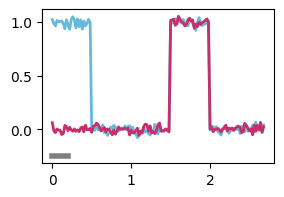

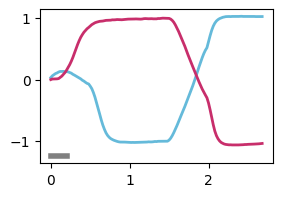

In [4]:
dms.stimulus1_duration_min = 500
dms.stimulus1_duration_max = 500
dms.delay_duration_min = 1000
dms.delay_duration_max = 1000
dms.stimulus2_duration_min = 500
dms.stimulus2_duration_max = 500
dms.decision_duration = 200
dms.setup()

x1 = dms.generate_dms_data(1, type='A-A')[0]
x2 = dms.generate_dms_data(1, type='B-A')[0]
outp1, traj1 = net1.forward(x1)
outp2, traj2 = net1.forward(x2)
x1, x2 = x1.squeeze().numpy(), x2.squeeze().numpy()
outp1 = outp1.detach().squeeze().numpy()
outp2 = outp2.detach().squeeze().numpy()

def time_mapping(t):
    return t * dms.deltaT / 1000

fig, ax = plt.subplots(figsize=(3, 2))

ax.plot(time_mapping(np.arange(x1.shape[0])), x1[:, 0], c='#65BADA', zorder=30, lw=2)
ax.plot(time_mapping(np.arange(x1.shape[0])), x2[:, 0], c='#C82E6B', zorder=30, lw=2)
ax.plot([0, 0.2], [-.25, -.25], c='gray', lw=4)


fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(time_mapping(np.arange(outp1.shape[0])), outp1, color='#65BADA', zorder=30, lw=2)
ax.plot(time_mapping(np.arange(outp1.shape[0])), outp2, color='#C82E6B', zorder=30, lw=2)
ax.plot([0, 0.2], [-1.25, -1.25], c='gray', lw=4)


Visualising two network populations

pop 0: slope=0.06, intercept=0.02
pop 1: slope=-0.24, intercept=-0.18
pop 0: slope=-0.01, intercept=-0.05
pop 1: slope=0.04, intercept=-0.01
pop 0: slope=0.03, intercept=0.17
pop 1: slope=-0.06, intercept=-0.22
pop 0: slope=0.74, intercept=0.00
pop 1: slope=0.70, intercept=0.08
pop 0: slope=-0.08, intercept=0.01
pop 1: slope=0.05, intercept=0.07
pop 0: slope=-0.01, intercept=-0.14
pop 1: slope=0.04, intercept=-0.05
pop 0: slope=-0.06, intercept=-0.32
pop 1: slope=0.09, intercept=0.38
pop 0: slope=0.72, intercept=-0.03
pop 1: slope=0.13, intercept=0.54


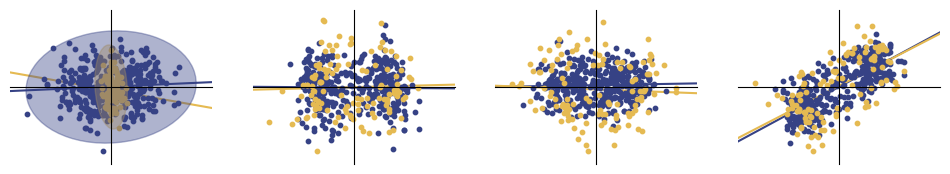

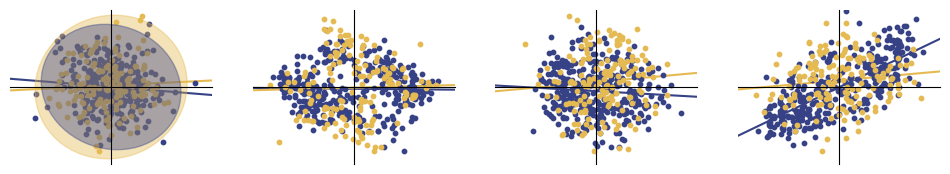

In [5]:
# Visualizing those 2 populations
helpers.plot_coefficients(net1)
helpers.plot_coefficients(net2)

# Create new network by fitting Gaussian mixture to the connectivity space

In [6]:
z1, net1_sampled_1 = helpers.sample_network(net1, 'dms_rank2_500_sampled_1.pt')
z2, net1_sampled_2 = helpers.sample_network(net1, 'dms_rank2_500_sampled_2.pt')

# Visualising two network populations

pop 0: slope=0.05, intercept=0.04
pop 1: slope=0.58, intercept=0.06
pop 0: slope=0.03, intercept=-0.04
pop 1: slope=0.11, intercept=0.23
pop 0: slope=0.05, intercept=0.08
pop 1: slope=0.02, intercept=0.55
pop 0: slope=0.76, intercept=-0.01
pop 1: slope=0.63, intercept=-0.09
pop 0: slope=-0.05, intercept=-0.02
pop 1: slope=-1.18, intercept=-0.03
pop 0: slope=-0.08, intercept=0.07
pop 1: slope=-0.07, intercept=-0.07
pop 0: slope=0.04, intercept=0.06
pop 1: slope=-0.03, intercept=0.14
pop 0: slope=0.77, intercept=0.03
pop 1: slope=0.79, intercept=-0.03


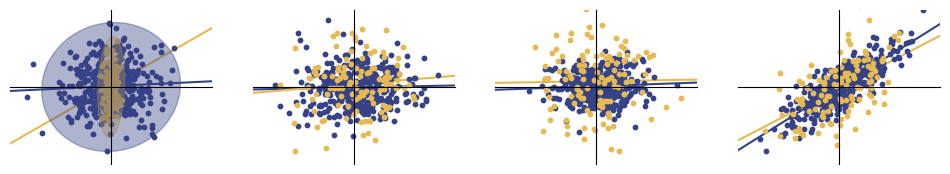

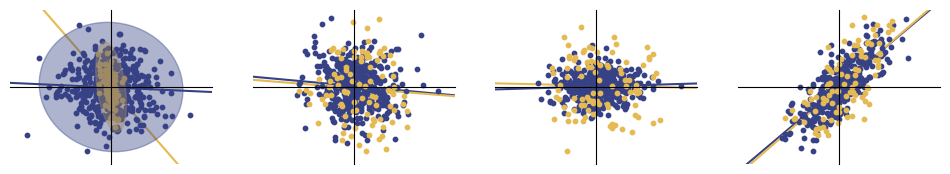

In [7]:
helpers.plot_coefficients(net1_sampled_1)
helpers.plot_coefficients(net1_sampled_2)

# Generate synthetic data

In [8]:
stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]


n_gains=20
gain = np.linspace(1, 0, n_gains)
    
input_data = torch.zeros(n_gains, decision, 2)
for i, g in enumerate(gain):
    input_data[i, stim1_begin:stim1_end, 0] = g
    input_data[i, stim2_begin:stim2_end, 0] = g
    
# uncomment below to generate trajectories (slow)    
"""
n_traj=200
traj11 = helpers.generate_trajectories(net1_sampled_1, input_data, epochs, n_traj, fname='data/RNN_trajectories11.pkl')
traj12 = helpers.generate_trajectories(net1_sampled_2, input_data, epochs, n_traj, fname='data/RNN_trajectories12.pkl')
traj2 = helpers.generate_trajectories(net2, input_data, epochs, n_traj, fname='RNN_trajectories2.pkl')
"""

traj11 = helpers.load_trajectories('data/RNN_trajectories11.pkl')
traj12 = helpers.load_trajectories('data/RNN_trajectories12.pkl')
traj2 = helpers.load_trajectories('data/RNN_trajectories2.pkl')

# Plot phase portraits of two different dynamics  

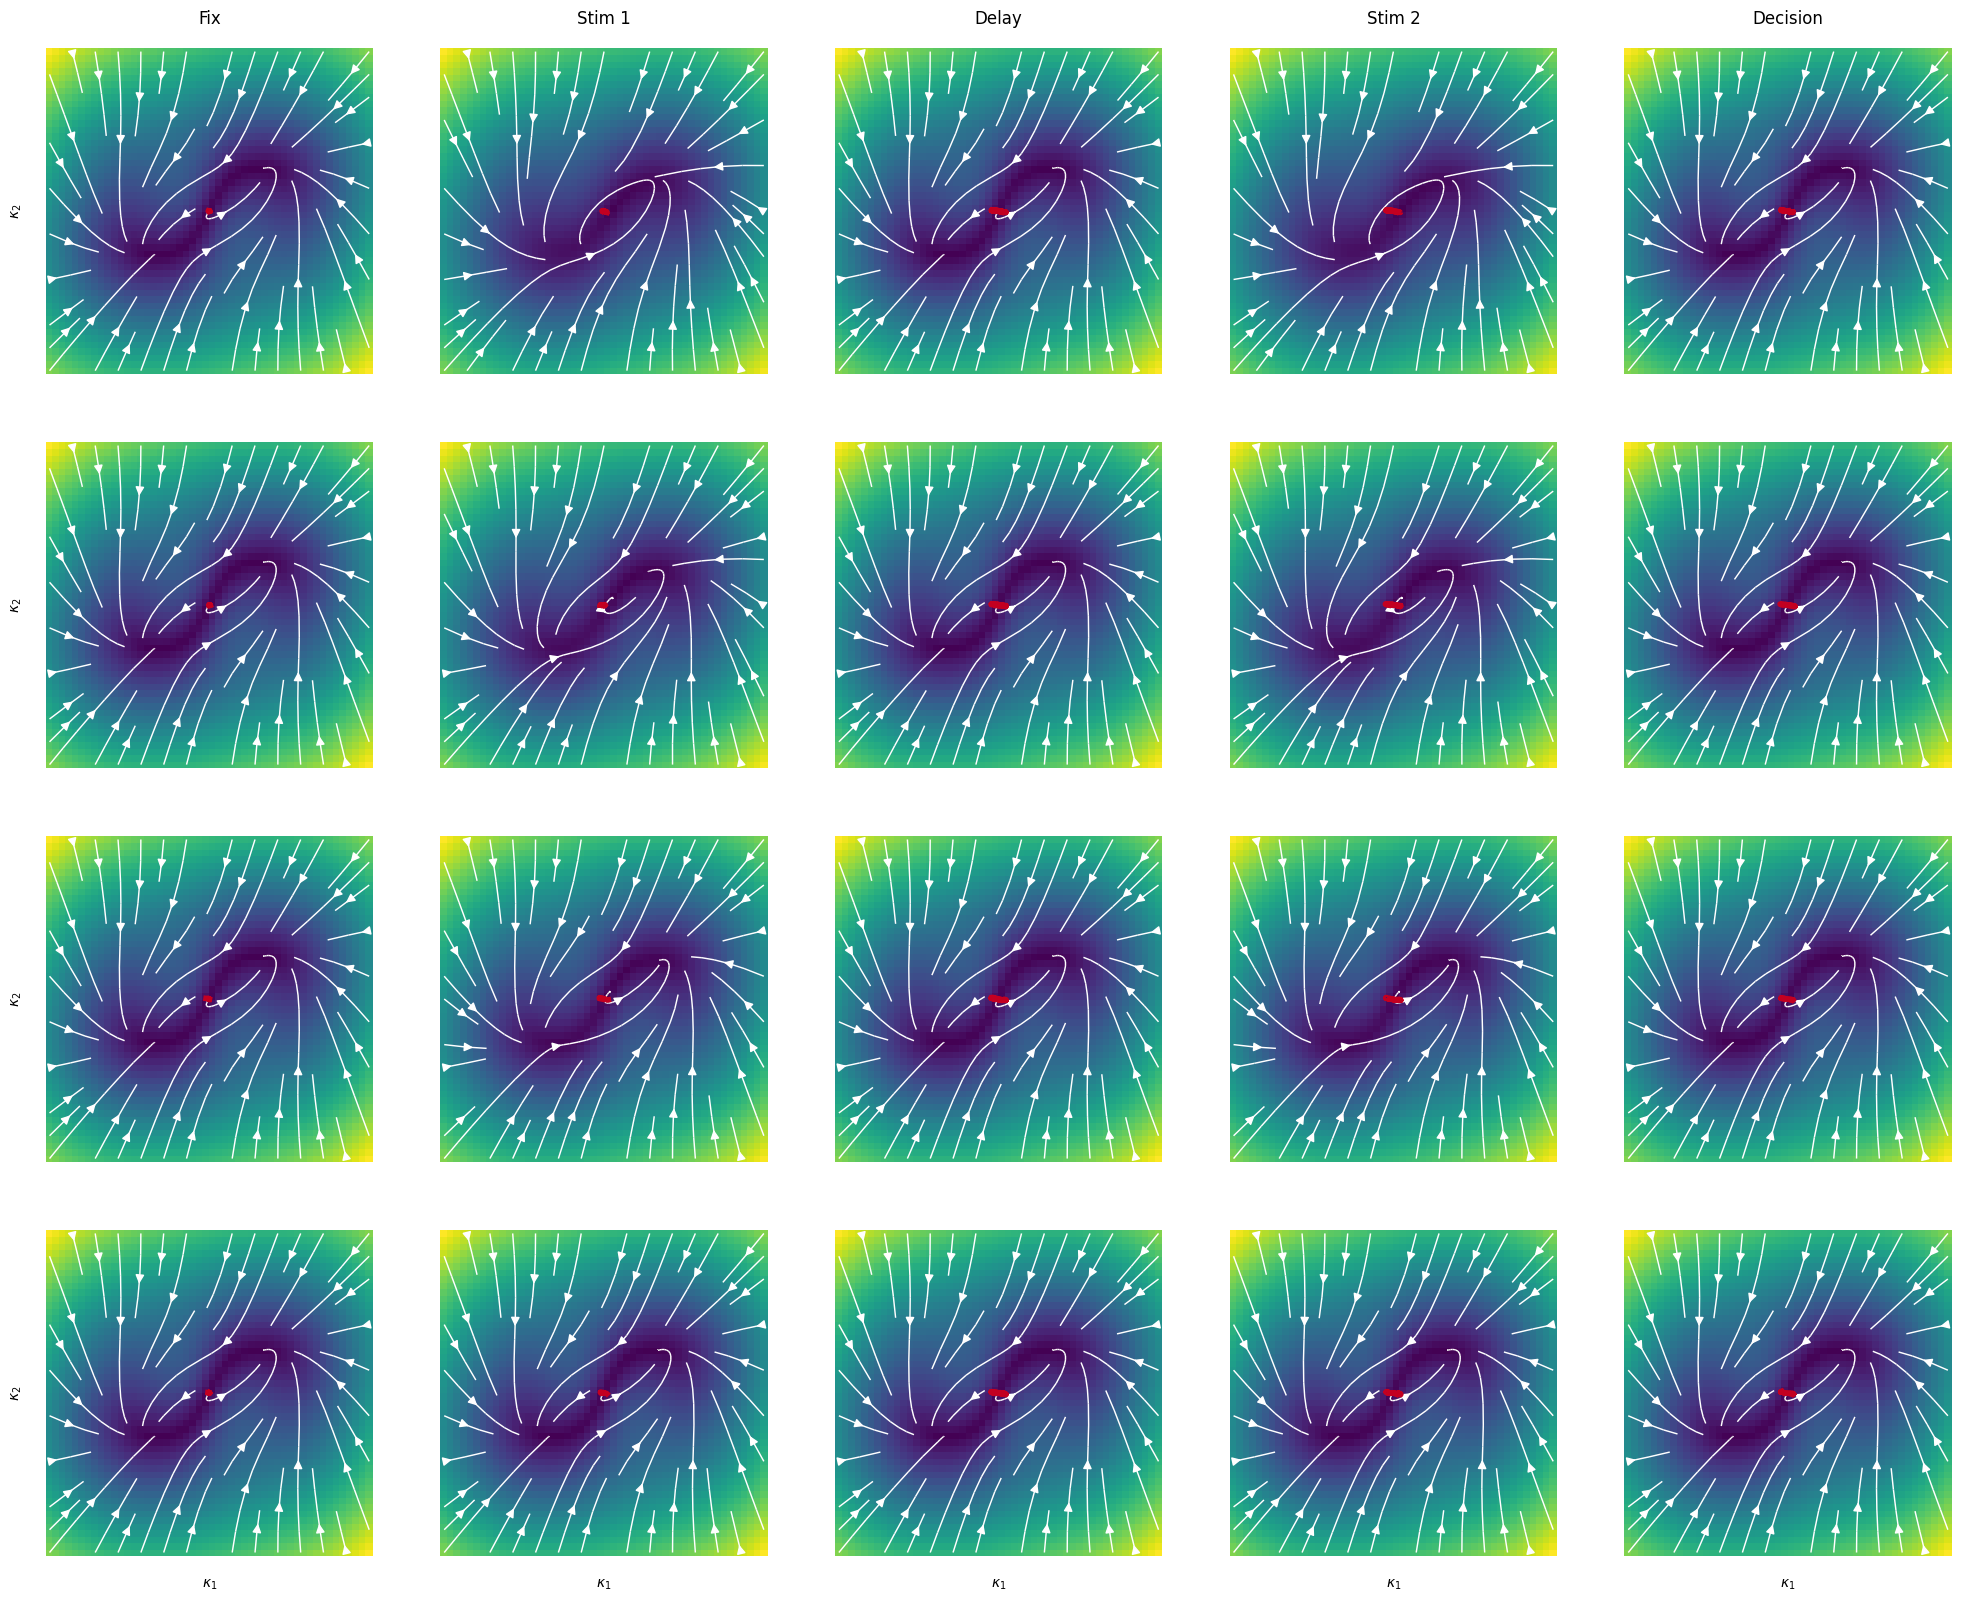

In [9]:
helpers.plot_experiment(net1_sampled_2, input_data, traj12, epochs, rect=(-6, 6, -4, 4), traj_to_show=1)

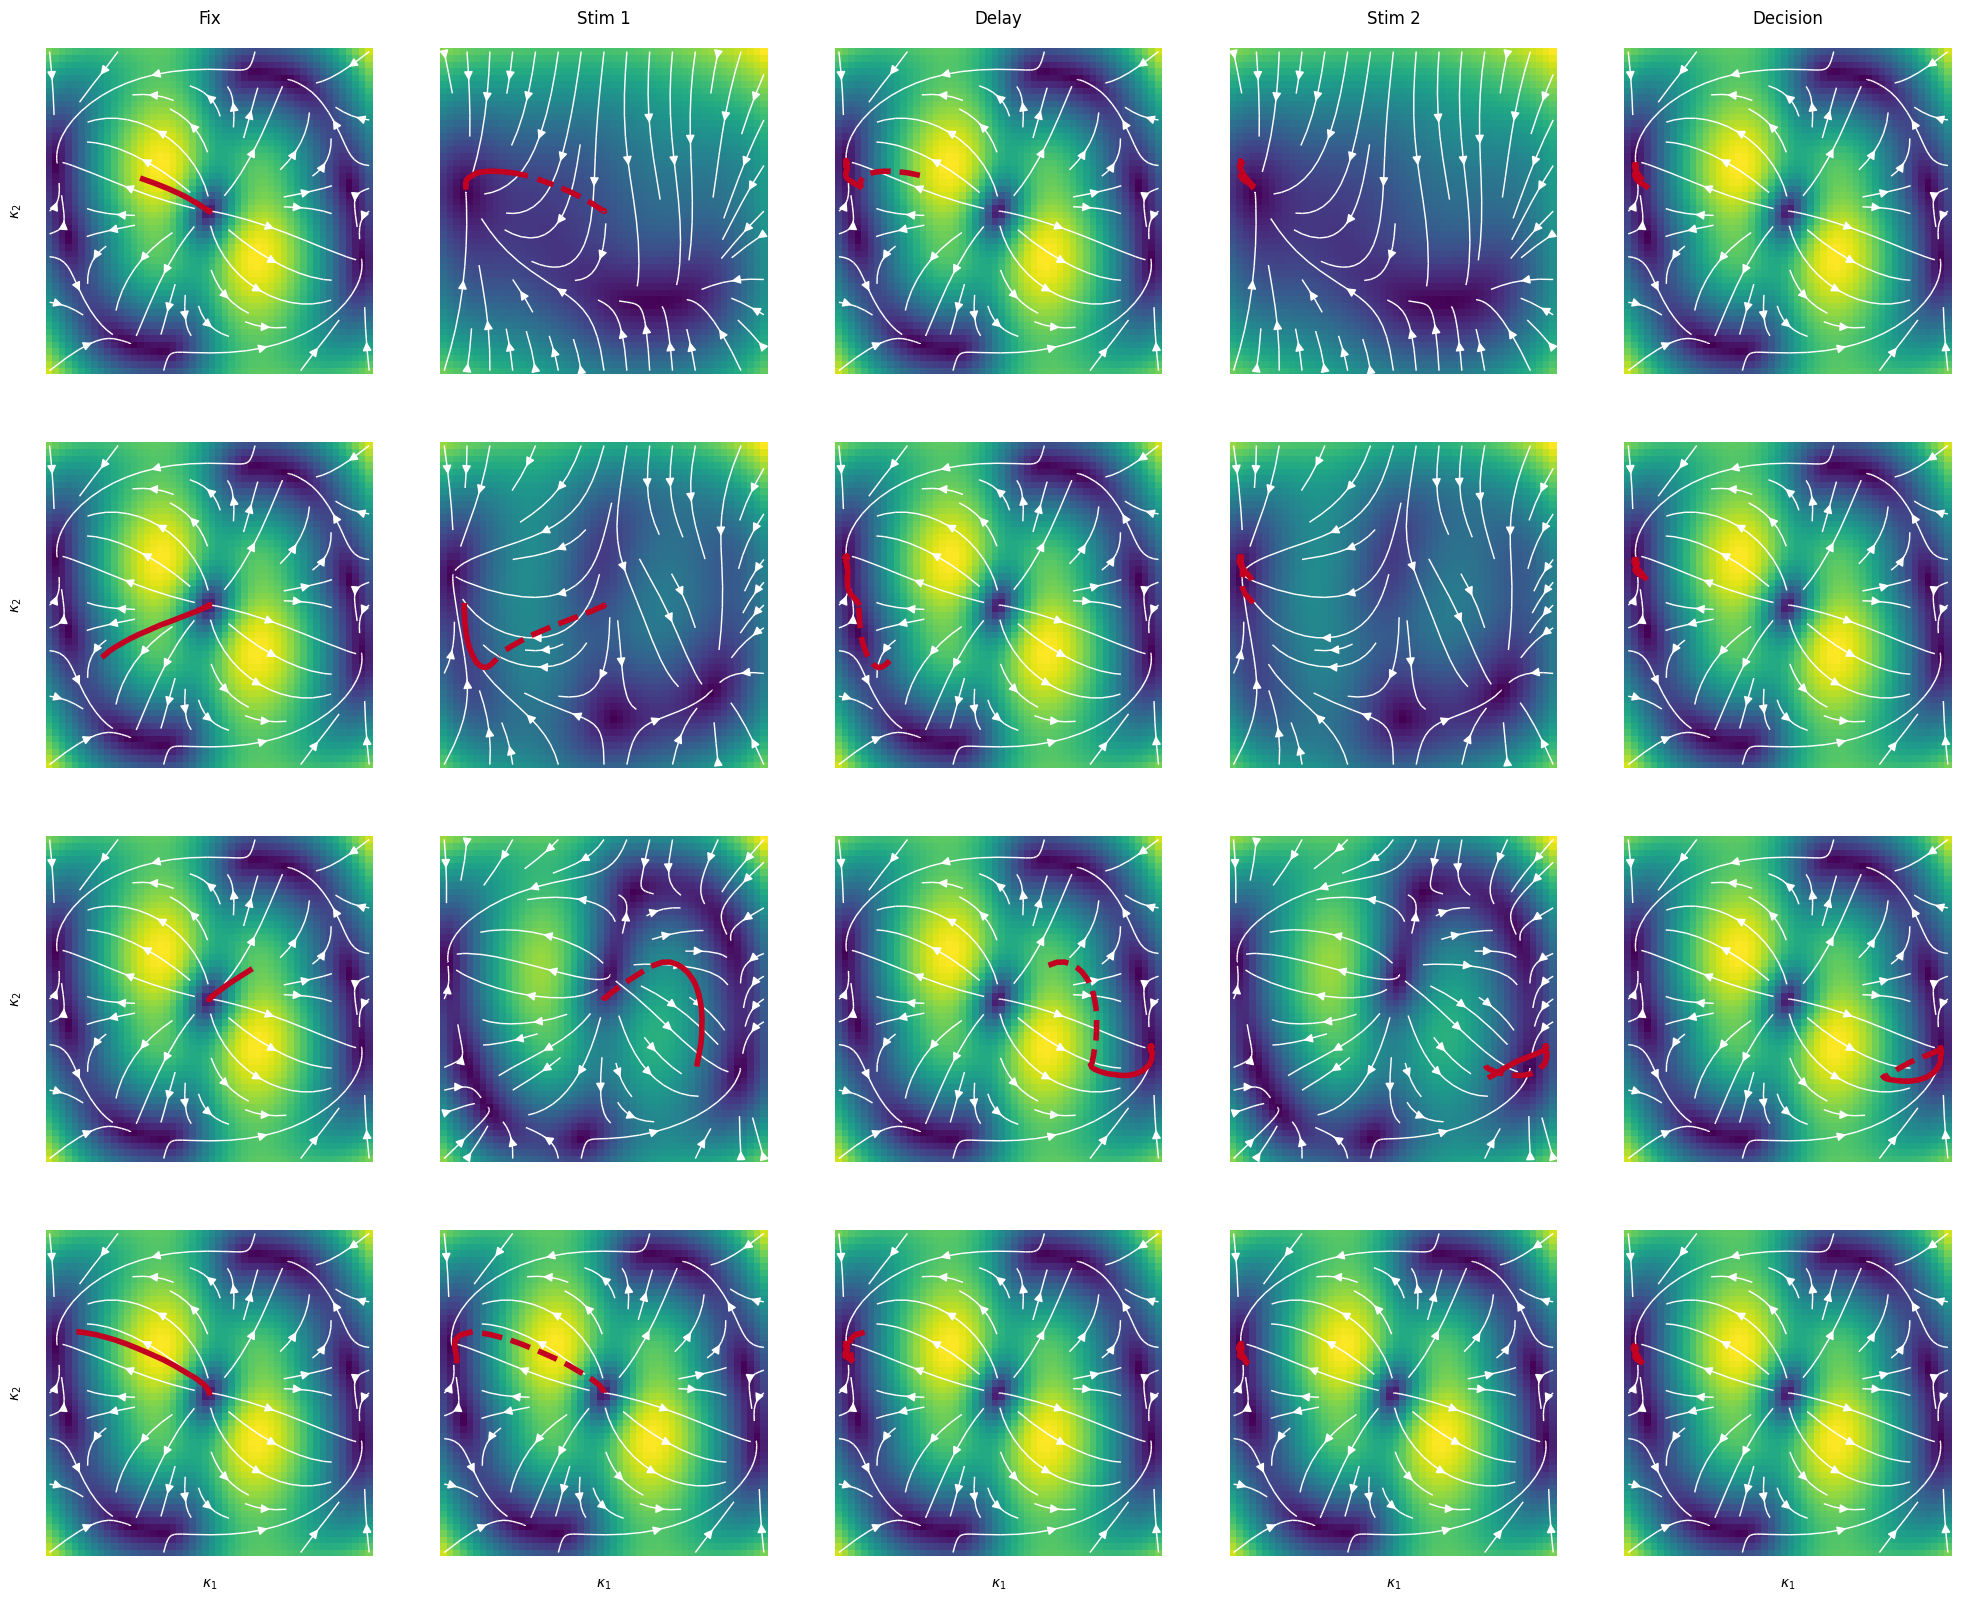

In [10]:
helpers.plot_experiment(net2, input_data, traj2, epochs, rect=(-6, 6, -4, 4), traj_to_show=1)

In [11]:
accuracy = []
for g in gain:
    _, _, _, x_val, y_val, mask_val = dms.generate_dms_data(10000, gain=g)
    loss, acc = dms.test_dms(net1, x_val, y_val, mask_val)
    accuracy.append(acc)
    

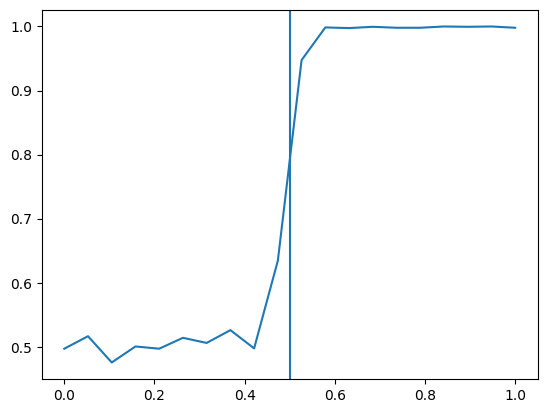

In [12]:
plt.plot(gain, accuracy)
plt.axvline(0.5)

# Concatenate data and create datasets

In [13]:
transient = 15
pos11, vel11 = helpers.aggregate_data(traj11, epochs, transient)
pos12, vel12 = helpers.aggregate_data(traj12, epochs, transient)
pos2, vel2 = helpers.aggregate_data(traj2, epochs, transient)

pos = pos11 + pos12 + pos2
vel = vel11 + vel12 + vel2

Explained variance:  [0.81798023 0.15322656 0.02377391]
Explained variance:  [0.81477934 0.14500892 0.03334008]
Explained variance:  [0.93479407 0.04114021 0.02298904]


# Train a model on network solution 1

In [22]:
data = MARBLE.construct_dataset(pos11, features=vel11, graph_type='cknn', k=15, stop_crit=0.01, local_gauges=False)

---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


In [23]:
params = {'epochs': 40, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 64, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': False,
      }

model = MARBLE.net(data, params=params)
model.run_training(data, outdir='data')


---- Settings: 

epochs : 40
order : 2
hidden_channels : 64
out_channels : 5
inner_product_features : False
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
frac_sampled_nb : -1
include_positions : False
include_self : True
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  39
---- Total number of parameters:  2886

---- Training network ...

Epoch: 0, Training loss: 1.137753, Validation loss: 1.0407, lr: 0.0100 *
Epoch: 1, Training loss: 1.018493, Validation loss: 1.0291, lr: 0.0100 *
Epoch: 2, Training loss: 1.001854, Validation loss: 1.0275, lr: 0.0100 *
Epoch: 3, Training loss: 0.985514, Validation loss: 0.9736, lr: 0.0100 *
Epoch: 4, Training loss: 0.968572, Validation loss: 0.9895, lr: 0.0100
Epoch: 5, Training loss: 0.961584, Validation loss: 0.9747, lr: 0.0100
Epoch: 6, Training loss: 0.953522, Validation loss: 0.9671, lr: 0.010

In [36]:
data = model.evaluate(data)
data = MARBLE.distribution_distances(data, n_clusters=60)

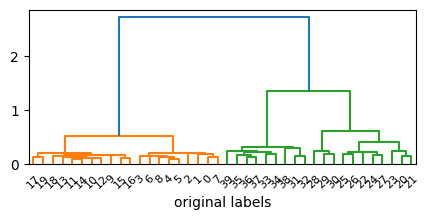

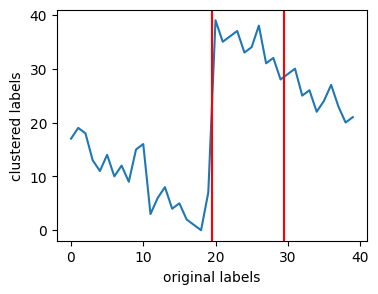

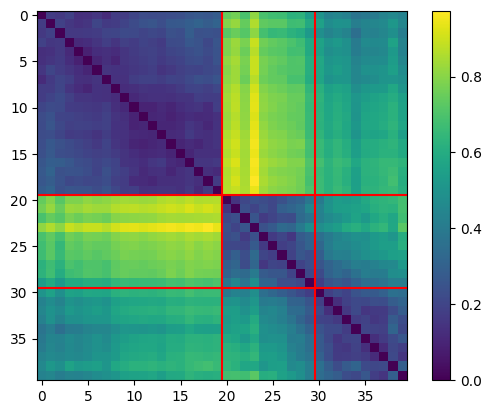

In [68]:
from scipy.cluster.hierarchy import dendrogram                                                          
from scipy.cluster.hierarchy import linkage                                                             
from scipy.spatial.distance import squareform   

def cluster_matrix(df, distance=False, ax=None):                                                                 
    """Return sorted labels to cluster a matrix with linkage.                                           
                                                                                                        
    If distance matrix already set distance=True.                                                       
    """                                                                                                 
                                                                                                        
    with np.errstate(divide="ignore", invalid="ignore"):                                                
        _data = df if distance else 1.0 / df                              
                                                                                                        
    _data[_data > 1e10] = 1000                                                                          
    np.fill_diagonal(_data, 0.0)                                                                        
    dists = squareform(_data)                                                                           
    Z = linkage(dists, "ward")                                                                          
    labels = np.arange(0, len(df))                                                                     
    dn = dendrogram(Z, labels=labels, ax=ax)                                                     
    return labels[dn["leaves"]]     

plt.figure(figsize=(5, 2))
l = cluster_matrix(data.dist, distance=True, ax=plt.gca())
plt.xlabel('original labels')

plt.figure(figsize=(4, 3))
plt.plot(np.arange(0, len(data.dist)), l)
plt.xlabel('original labels')
plt.ylabel('clustered labels')
plt.axvline(len(data.dist)/2-0.5, c='r')
plt.axvline(3*len(data.dist)/4-0.5, c='r')

plt.figure()
im = plt.imshow(data.dist)
plt.colorbar(im)
plt.axhline(len(data.dist)/2-0.5, c='r')
plt.axhline(3*len(data.dist)/4-0.5, c='r')
plt.axvline(len(data.dist)/2-0.5, c='r')
plt.axvline(3*len(data.dist)/4-0.5, c='r')

Performed MDS embedding on embedded results.


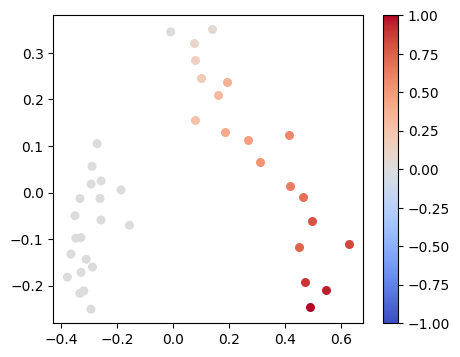

In [69]:
labels = [0. for g in gain] + [g for g in gain]

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot()
emb_MDS, _ = geometry.embed(data.dist, embed_typ='MDS')
ax = plotting.embedding(emb_MDS, labels, ax=ax, s=30, alpha=1, axes_visible=True)

# Train network with solution I and solution II (slow)

In [ ]:
data2 = MARBLE.construct_dataset(pos, features=vel, graph_type='cknn', k=15, stop_crit=0.01, local_gauges=False)

In [ ]:
params = {'epochs': 40, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 64, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model2 = MARBLE.net(data2, params=params)
model2.run_training(data2, outdir='data')

In [ ]:
data2 = model.evaluate(data2)
data2 = MARBLE.distribution_distances(data2)

In [ ]:
n = len(data2.dist) // 6
dist = data2.dist[:2 * n,:2 * n]
ind = list(range(n,2 * n)) + list(range(3 * n,4 * n)) + list(range(5 * n,6 * n))
dist = data.dist[ind,:][:,ind]
im = plt.imshow(dist)
plt.colorbar(im)

In [ ]:
labels = [g for g in gain ]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
emb_MDS, _ = geometry.embed(dist, embed_typ = 'MDS')
ax = plotting.embedding(emb_MDS[:n], labels, ax=ax, s=30, alpha=1, axes_visible=True)
ax = plotting.embedding(emb_MDS[n:2*n], labels, ax=ax, s=30, alpha=1, axes_visible=True, cmap='PuOr')
ax = plotting.embedding(emb_MDS[2*n:], labels, ax=ax, s=30, alpha=1, axes_visible=True, cmap='PRGn')
